In [123]:
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

In [2]:
# import data
XYZloan = pd.read_csv("XYZloan_default_selected_vars.csv")
XYZloan.head(n=3)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


# Data Preparation

In [3]:
XYZloan=XYZloan.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1) #delete useless columns
XYZloan.head(n=3)

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,3,0,33,1,4,12,2017/7/1 14:11,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


In [4]:
XYZloan.shape

(80000, 87)

In [5]:
XYZloan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 87 columns):
id              80000 non-null int64
loan_default    80000 non-null int64
AP001           80000 non-null int64
AP002           80000 non-null int64
AP003           80000 non-null int64
AP004           80000 non-null int64
AP005           80000 non-null object
AP006           80000 non-null object
AP007           80000 non-null int64
AP008           80000 non-null int64
AP009           80000 non-null int64
TD001           80000 non-null int64
TD002           80000 non-null int64
TD005           80000 non-null int64
TD006           80000 non-null int64
TD009           80000 non-null int64
TD010           80000 non-null int64
TD013           80000 non-null int64
TD014           80000 non-null int64
TD015           80000 non-null int64
TD022           60402 non-null float64
TD023           72337 non-null float64
TD024           76306 non-null float64
TD025           77450 non-null f

In [6]:
# convert data type of AP005 column to datetime format
XYZloan['AP005']= pd.to_datetime(XYZloan['AP005'])

### Dealing with Missing Value

In [7]:
missingV = XYZloan.isnull().sum().sort_values(ascending=False)
percent = (XYZloan.isnull().sum()/XYZloan.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missingV, percent], axis=1, keys=['missing_value_num', 'missing_value_percent'])

,missing_value_num,missing_value_percent
TD055,79999,0.999988
TD062,79999,0.999988
TD048,79999,0.999988
TD044,79997,0.999962
TD051,79995,0.999938
TD061,79990,0.999875
TD054,79988,0.999850
TD022,19598,0.244975
TD023,7663,0.095787
TD024,3694,0.046175


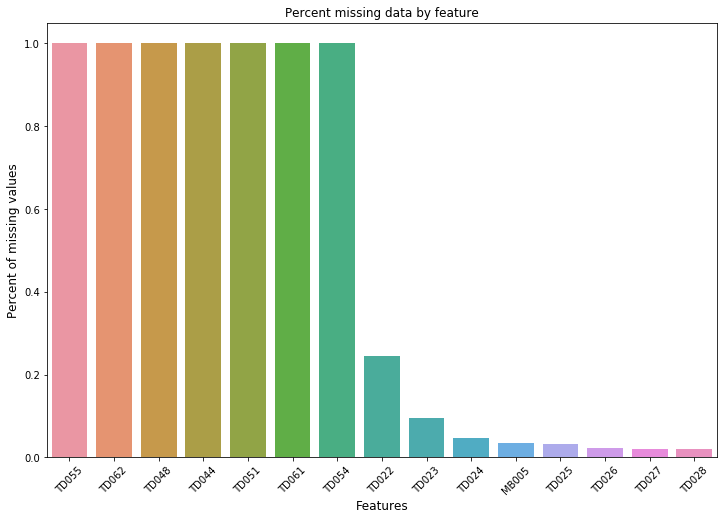

In [8]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='45')
sns.barplot(x=missing_data.head(n=15).index, y=missing_data.head(n=15)['missing_value_percent'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percent of missing values', fontsize=12)
plt.title('Percent missing data by feature', fontsize=12)
missing_data.head(n=15)

#### By exploring the XYZloan data, I found that columns: TD055, TD062, TD048, TD044, TD051, TD061,and TD054 have over 99% of missing values. For my later analysis and modeling, I will delect these 7 columns. Also, the column: TD022 has about 25% missing values, I will impute all the missing value with median.

In [9]:
XYZloan=XYZloan.drop(["TD055","TD062","TD048","TD044","TD051","TD061","TD054"], axis=1)
XYZloan.shape

(80000, 80)

### Deal with "AP005" (datetime)
Extract Year, Month and day out from AP005

In [10]:
XYZloan.head(n=3)

,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,2,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,3,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


In [11]:
# Extract year, month and weekday from the datetime data in AP005
XYZloan['year'] = pd.DatetimeIndex(XYZloan['AP005']).year
XYZloan['month'] = pd.DatetimeIndex(XYZloan['AP005']).month
XYZloan['weekday'] = pd.DatetimeIndex(XYZloan['AP005']).weekday_name

In [12]:
XYZloan=XYZloan.drop(["AP005"], axis=1)
print(XYZloan.shape)
XYZloan.head(n=3)

(80000, 82)


,id,loan_default,AP001,AP002,AP003,AP004,AP006,AP007,AP008,AP009,...,CD167,CD169,CD170,CD172,CD173,MB005,MB007,year,month,weekday
0,1,1,31,2,1,12,ios,3,3,1,...,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,2017,7,Thursday
1,2,0,27,1,1,12,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB,2017,4,Thursday
2,3,0,33,1,4,12,h5,4,2,0,...,0.0,33.0,0.0,143.0,110.0,8.0,WEB,2017,7,Saturday


### Impute Missing Values

In [13]:
#replace NA with median of columns where they are 
XYZloan=XYZloan.fillna(XYZloan.median())

### check number like 0, -1, -99, -98
These kind of data might not really makes sense when modeling

In [14]:
check_list=[-1,-99,-98]
col_name = []
count = 0
for i in XYZloan.columns:
    if XYZloan[i].isin(check_list).sum()> 0:
        col_name.append(i)        
print(len(col_name))
col_name

42


['PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173']

In [15]:
df_special_n = pd.DataFrame()
for i in col_name:
    df1 = XYZloan[i].value_counts().to_frame().head(n=10).reset_index()
    df_special_n = pd.concat([df_special_n, df1], axis=1, sort=False)
df_special_n

,index,PA022,index,PA023,index,PA028,index,PA029,index,PA030,...,index,CD167,index,CD169,index,CD170,index,CD172,index,CD173
0,-1.0,51020,-1.0,56385,-98.0,51020,-98.0,53467,-98.0,68267,...,0.0,14917,0.0,4876,0.0,7430,-99.0,3307,0.0,4463
1,-99.0,1534,-99.0,1534,-99.0,1534,-99.0,1534,-99.0,1534,...,-99.0,3307,-99.0,3307,-99.0,3307,0.0,2674,-99.0,3307
2,91.0,431,91.0,345,22.0,232,0.0,236,0.0,94,...,397.0,431,1023.0,400,870.0,408,1553.0,397,1324.0,395
3,92.0,397,92.0,329,0.0,229,22.0,234,20.0,91,...,73.0,86,59.0,63,132.0,58,78.0,42,93.0,48
4,94.0,391,87.0,319,20.0,227,20.0,221,21.0,90,...,74.0,82,78.0,60,58.0,57,351.0,41,148.0,46
5,93.0,383,89.0,312,23.0,217,23.0,218,18.0,88,...,158.0,80,106.0,56,102.0,57,33.0,41,584.0,45
6,88.0,382,94.0,312,21.0,217,21.0,215,16.0,77,...,124.0,79,58.0,56,78.0,56,14.0,40,78.0,44
7,87.0,376,90.0,310,18.0,215,18.0,203,23.0,77,...,147.0,78,112.0,56,112.0,56,87.0,40,259.0,44
8,89.0,374,88.0,303,19.0,200,19.0,199,19.0,77,...,164.0,78,347.0,56,184.0,55,64.0,39,119.0,44
9,86.0,370,86.0,290,16.0,197,32.0,195,22.0,76,...,91.0,77,24.0,55,118.0,54,259.0,39,87.0,43


In [16]:
# find column name with more than 40000 data in -1, -99 or -98
np.where(df_special_n.iloc[0,1::2]>40000)

(array([0, 1, 2, 3, 4, 5]),)

In [17]:
df_special_n.iloc[0,1::2].head(n=6)

PA022    51020.0
PA023    56385.0
PA028    51020.0
PA029    53467.0
PA030    68267.0
PA031    56385.0
Name: 0, dtype: float64

In [18]:
#delete the columns: PA002, PA023, PA028, PA029, PA030, PA031
XYZloan=XYZloan.drop(['PA022', 'PA023',"PA028","PA029","PA030","PA031"], axis=1)
XYZloan.head(n=3)

,id,loan_default,AP001,AP002,AP003,AP004,AP006,AP007,AP008,AP009,...,CD167,CD169,CD170,CD172,CD173,MB005,MB007,year,month,weekday
0,1,1,31,2,1,12,ios,3,3,1,...,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,2017,7,Thursday
1,2,0,27,1,1,12,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,5.0,WEB,2017,4,Thursday
2,3,0,33,1,4,12,h5,4,2,0,...,0.0,33.0,0.0,143.0,110.0,8.0,WEB,2017,7,Saturday


In [19]:
col_CD=XYZloan[[col for col in XYZloan if col.startswith('CD')]]
for i in col_CD.columns:
    
    print(col_CD[i].value_counts()[col_CD[i].value_counts().index<=0]) 


-99.0    3307
 0.0      683
Name: CD008, dtype: int64
-99.0    3307
 0.0      156
Name: CD018, dtype: int64
 0.0     15718
-99.0     3307
Name: CD071, dtype: int64
 0.0     15403
-99.0     3307
Name: CD072, dtype: int64
 0.0     13669
-99.0     3307
Name: CD088, dtype: int64
 0.0     26699
-99.0     3307
Name: CD100, dtype: int64
 0.0     34238
-99.0     3307
Name: CD101, dtype: int64
 0.0     20487
-99.0     3307
Name: CD106, dtype: int64
 0.0     27859
-99.0     3307
Name: CD107, dtype: int64
 0.0     30579
-99.0     3307
Name: CD108, dtype: int64
 0.0     26699
-99.0     3307
Name: CD113, dtype: int64
 0.0     20487
-99.0     3307
Name: CD114, dtype: int64
-99.0    3307
 0.0      521
Name: CD115, dtype: int64
-99.0    3307
 0.0      678
Name: CD117, dtype: int64
-99.0    3307
 0.0      290
Name: CD118, dtype: int64
-99.0    3307
 0.0      394
Name: CD120, dtype: int64
-99.0    3307
 0.0      141
Name: CD121, dtype: int64
-99.0    3307
 0.0      218
Name: CD123, dtype: int64
-99.0   

#### Based on the results, I knew it only contains two kinds of unresonable data: 0 and -99 in those CD list 

In [20]:
# Create a copy of XYZloan
XYZloan_copy = XYZloan.copy()

### Create bins
As there are many -99 and 0 in all CDs columns, but those values should have their own meaning. So, I will make bins to keep these values because they could be important to interpret the whole dataset. 

In [21]:
for col in col_CD.columns.tolist():   
    XYZloan_copy[col+"_bin"] = pd.qcut(XYZloan_copy[col][(XYZloan_copy[col]!=0)&(XYZloan_copy[col]!=-99)],q=10,precision=0,duplicates="drop")
    XYZloan_copy[col+"_bin"] = XYZloan_copy[col+"_bin"].cat.add_categories(['0'])
    XYZloan_copy[col+"_bin"] = XYZloan_copy[col+"_bin"].cat.add_categories(['-99'])
    XYZloan_copy[col+"_bin"].iloc[np.where(XYZloan_copy[col]==0.0)[0]]='0'
    XYZloan_copy[col+"_bin"].iloc[np.where(XYZloan_copy[col]==-99.0)[0]]='-99'
    

In [22]:
XYZloan_copy=XYZloan_copy.drop(col_CD.columns.tolist(),axis=1)
XYZloan_copy.head(n=3)

,id,loan_default,AP001,AP002,AP003,AP004,AP006,AP007,AP008,AP009,...,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin
0,1,1,31,2,1,12,ios,3,3,1,...,"(12420.0, 15677.0]","(6.0, 8.0]","(10.0, 13.0]","(11.0, 14.0]",0,0,"(1204.0, 1609.0]","(1099.0, 1471.0]","(1736.0, 2290.0]","(2057.0, 2733.0]"
1,2,0,27,1,1,12,h5,5,4,0,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,3,0,33,1,4,12,h5,4,2,0,...,"(10.0, 2613.0]",0,"(0.0, 3.0]","(0.0, 2.0]","(0.0, 101.0]",0,"(0.0, 179.0]",0,"(0.0, 265.0]","(0.0, 237.0]"


In [23]:
# "AP004" is a bad data field and should be removed: about 90% of data in AP004 column is 12, which is not helpful in modeling 
print(XYZloan_copy.AP004.value_counts())
XYZloan_copy=XYZloan_copy.drop(["AP004"],axis = 1)
XYZloan_copy.shape


12    70357
6      3926
3      3410
9      2307
Name: AP004, dtype: int64


(80000, 75)

### Take a look of "CR009"
"CR009" represents amount of loan in the dataset, which could be important for prediction of loan default. Something I have done for analysis "CR009" are listed as follows:
* Did a histogram plot to see the distribution of loan amount
* Used describe function to see the number in different percentail
* Create bins for loan amount

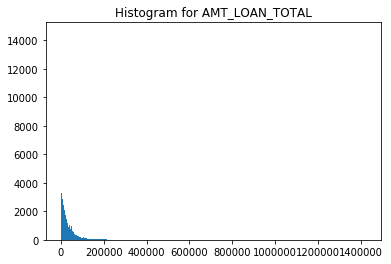

In [24]:
plt.hist(XYZloan_copy['CR009'], bins='auto')  
plt.title("Histogram for AMT_LOAN_TOTAL")
plt.show()

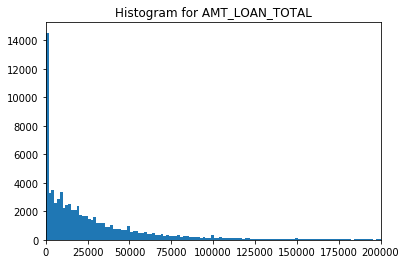

In [25]:
#CR009:AMT_LOAN_TOTAL distribution
plt.hist(XYZloan_copy['CR009'], bins='auto')  
plt.title("Histogram for AMT_LOAN_TOTAL")
plt.xlim(0,200000)
plt.show()

In [26]:
XYZloan_copy['CR009'].describe()

count    8.000000e+04
mean     3.518711e+04
std      6.359684e+04
min      0.000000e+00
25%      4.700000e+03
50%      1.728500e+04
75%      4.075000e+04
max      1.420300e+06
Name: CR009, dtype: float64

In [27]:
pd.qcut(XYZloan_copy['CR009'], q=4,precision=0).value_counts(sort=False)

(-1.0, 4700.0]          20006
(4700.0, 17285.0]       19994
(17285.0, 40750.0]      20001
(40750.0, 1420300.0]    19999
Name: CR009, dtype: int64

In [28]:
pd.qcut(XYZloan_copy['CR009'], q=5,precision=0).value_counts(sort=False)

(-1.0, 2500.0]          16337
(2500.0, 11499.0]       15669
(11499.0, 24296.0]      15994
(24296.0, 50000.0]      16296
(50000.0, 1420300.0]    15704
Name: CR009, dtype: int64

In [29]:
#qcut: divide into equal sized bins
qcut5_label=[1,2,3,4,5]
XYZloan_copy['qcut_5'] = pd.qcut(XYZloan_copy['CR009'],q=5,labels=qcut5_label,precision=0)

In [30]:
#Drop column CR009 after set different bins
XYZloan_copy=XYZloan_copy.drop("CR009",axis=1)

In [31]:
XYZloan_copy.head(n=3)

,id,loan_default,AP001,AP002,AP003,AP006,AP007,AP008,AP009,TD001,...,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,qcut_5
0,1,1,31,2,1,ios,3,3,1,1,...,"(6.0, 8.0]","(10.0, 13.0]","(11.0, 14.0]",0,0,"(1204.0, 1609.0]","(1099.0, 1471.0]","(1736.0, 2290.0]","(2057.0, 2733.0]",4
1,2,0,27,1,1,h5,5,4,0,2,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,2
2,3,0,33,1,4,h5,4,2,0,2,...,0,"(0.0, 3.0]","(0.0, 2.0]","(0.0, 101.0]",0,"(0.0, 179.0]",0,"(0.0, 265.0]","(0.0, 237.0]",4


### Get dummy variable 
* AP006
* MB007
* qcut_5
* year
* month
* weekday
* all CD bin

In [32]:
XYZloan_copy["year"]= XYZloan_copy["year"].astype(object) 
XYZloan_copy["month"]= XYZloan_copy["month"].astype(object) 

In [33]:
XYZloan_copy["year"].value_counts()

2017    80000
Name: year, dtype: int64

In [34]:
#all the data in year 2017, so I drop the column: year
XYZloan_copy=XYZloan_copy.drop("year",axis=1)

In [35]:
XYZloan_dummy=pd.concat([XYZloan_copy.drop(['AP006',"MB007","qcut_5","month","weekday"], axis=1), pd.get_dummies(XYZloan_copy[["AP006","MB007",'qcut_5',"month","weekday"]],drop_first=True)], axis=1)
XYZloan_dummy.shape

(80000, 197)

In [36]:
cdbin = [col for col in XYZloan_copy if col.startswith('CD')]
XYZloan_dummy=pd.concat([XYZloan_dummy.drop(cdbin, axis=1), pd.get_dummies(XYZloan_dummy[cdbin],drop_first=True)], axis=1)
XYZloan_dummy.shape

(80000, 541)

In [37]:
#drop column: id
XYZloan_dummy=XYZloan_dummy.drop("id",axis=1)
XYZloan_dummy.head(n=3)

,loan_default,AP001,AP002,AP003,AP007,AP008,AP009,TD001,TD002,TD005,...,"CD173_bin_(506.0, 810.0]","CD173_bin_(810.0, 1154.0]","CD173_bin_(1154.0, 1552.0]","CD173_bin_(1552.0, 2057.0]","CD173_bin_(2057.0, 2733.0]","CD173_bin_(2733.0, 3722.0]","CD173_bin_(3722.0, 5628.0]","CD173_bin_(5628.0, 87312.0]",CD173_bin_0,CD173_bin_-99
0,1,31,2,1,3,3,1,1,1,4,...,0,0,0,0,1,0,0,0,0,0
1,0,27,1,1,5,4,0,2,0,3,...,0,0,0,0,0,0,0,0,0,1
2,0,33,1,4,4,2,0,2,1,4,...,0,0,0,0,0,0,0,0,0,0


# Pre-selection with H2O Random Forest
I use the parameters in the H2O random forest model the same as the one has best performance in the previous assignment. 

In [38]:
from sklearn.model_selection import train_test_split
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [39]:
train, test = train_test_split(XYZloan_dummy, test_size=0.33, random_state=123)
train.shape

(53600, 540)

In [40]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,14 days 8 hours 6 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_rona_2297nz
H2O cluster total nodes:,1
H2O cluster free memory:,145.6 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [41]:
target='loan_default'

In [42]:
predictors= train.iloc[:,1:].columns.tolist()

In [43]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [45]:
performance = rf_v1.model_performance(test_data=test_hex)
print(performance)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.1470757673668729
RMSE: 0.38350458584855657
MAE: 0.2978647439071035
RMSLE: 0.2693316346452558
Mean Residual Deviance: 0.1470757673668729



In [46]:
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,300.0,300.0,973730.0,15.0,20.0,17.926666,240.0,263.0,251.64333




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.1487150620738092
RMSE: 0.38563591906591016
MAE: 0.29913500476590915
RMSLE: 0.2703101643525273
Mean Residual Deviance: 0.1487150620738092

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1487877860849709
RMSE: 0.38573019856496965
MAE: 0.2993029228093306
RMSLE: 0.2703600243815201
Mean Residual Deviance: 0.1487877860849709

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.29929587,0.0018788108,0.29631925,0.29791695,0.29976344,0.29923624,0.29895127,0.30361912,0.29815388,0.2999845,0.29927394,0.29974008
1,mean_residual_deviance,0.1487836,0.0023220624,0.14558606,0.14875083,0.1494705,0.14807475,0.14828801,0.1544172,0.14657211,0.1486752,0.149418,0.1485833
2,mse,0.1487836,0.0023220624,0.14558606,0.14875083,0.1494705,0.14807475,0.14828801,0.1544172,0.14657211,0.1486752,0.149418,0.1485833
3,r2,0.050784584,0.0050454107,0.052804004,0.048747677,0.058032088,0.045252718,0.05028164,0.04426026,0.058589876,0.05249829,0.045350935,0.052028343
4,residual_deviance,0.1487836,0.0023220624,0.14558606,0.14875083,0.1494705,0.14807475,0.14828801,0.1544172,0.14657211,0.1486752,0.149418,0.1485833
5,rmse,0.3857143,0.002996325,0.3815574,0.38568228,0.38661414,0.38480482,0.38508183,0.39295954,0.38284737,0.38558424,0.38654625,0.38546503
6,rmsle,0.27035227,0.0016886326,0.26800725,0.2701006,0.2703633,0.2702948,0.270083,0.27438635,0.26852772,0.27039212,0.27100065,0.2703671



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2019-12-02 01:29:34,1:00:55.080,0.0,NaN,NaN,NaN
1,,2019-12-02 01:29:34,1:00:55.667,1.0,0.396216,0.300296,0.156987
2,,2019-12-02 01:29:35,1:00:56.805,2.0,0.393351,0.299767,0.154725
3,,2019-12-02 01:29:36,1:00:57.414,3.0,0.392457,0.299405,0.154023
4,,2019-12-02 01:29:37,1:00:58.489,4.0,0.392015,0.299820,0.153676
5,,2019-12-02 01:29:41,1:01:02.499,9.0,0.388128,0.298660,0.150643
6,,2019-12-02 01:29:45,1:01:06.923,14.0,0.387274,0.298752,0.149981
7,,2019-12-02 01:29:49,1:01:10.966,19.0,0.386788,0.298811,0.149605
8,,2019-12-02 01:29:54,1:01:15.447,24.0,0.386552,0.298909,0.149422
9,,2019-12-02 01:29:59,1:01:20.454,30.0,0.386273,0.298796,0.149207



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,TD013,21514.400391,1.000000,0.161077
1,AP003,18591.158203,0.864126,0.139191
2,TD009,15724.861328,0.730899,0.117731
3,TD005,7872.983398,0.365940,0.058945
4,TD014,6478.334961,0.301116,0.048503
5,MB005,6322.742188,0.293884,0.047338
6,CR015,5028.934570,0.233747,0.037651
7,TD010,2796.822021,0.129998,0.020940
8,TD023,2470.488037,0.114830,0.018496
9,AP001,2466.546875,0.114646,0.018467



See the whole table with table.as_data_frame()


In [47]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)


In [48]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



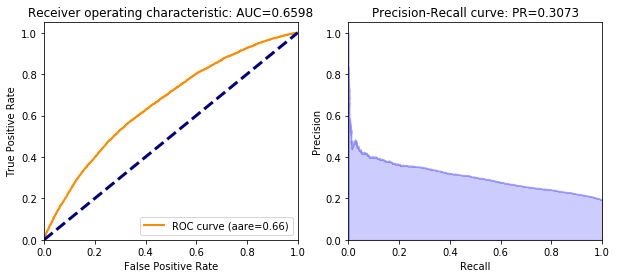

In [49]:
ROC_AUC(rf_v1,test_hex,'loan_default')

In [50]:
createGains(rf_v1)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2640,961,1679,2640,961,1679,0.19,0.08,505.5,1.90,11.0,36.40
1,2640,802,1838,5280,1763,3517,0.35,0.16,1011.0,1.74,19.0,33.39
2,2640,663,1977,7920,2426,5494,0.48,0.26,1516.5,1.60,22.0,30.63
3,2640,537,2103,10560,2963,7597,0.59,0.36,2022.0,1.47,23.0,28.06
4,2640,472,2168,13200,3435,9765,0.68,0.46,2527.5,1.36,22.0,26.02
5,2640,442,2198,15840,3877,11963,0.77,0.56,3033.0,1.28,21.0,24.48
6,2640,394,2246,18480,4271,14209,0.84,0.67,3538.5,1.21,17.0,23.11
7,2640,340,2300,21120,4611,16509,0.91,0.77,4044.0,1.14,14.0,21.83
8,2640,267,2373,23760,4878,18882,0.96,0.88,4549.5,1.07,8.0,20.53


In [51]:
rf_v1.varimp(True).head(n=30)

,variable,relative_importance,scaled_importance,percentage
0,TD013,21514.400391,1.000000,0.161077
1,AP003,18591.158203,0.864126,0.139191
2,TD009,15724.861328,0.730899,0.117731
3,TD005,7872.983398,0.365940,0.058945
4,TD014,6478.334961,0.301116,0.048503
5,MB005,6322.742188,0.293884,0.047338
6,CR015,5028.934570,0.233747,0.037651
7,TD010,2796.822021,0.129998,0.020940
8,TD023,2470.488037,0.114830,0.018496
9,AP001,2466.546875,0.114646,0.018467


In [52]:
# select top 30 important variable for scikit-learn random forest model
top30_var=rf_v1.varimp(True)['variable'].tolist()

##  Scikit-Learn random forest model
Because the dataset is too huge, I choose to use 20% sample data to run the scikit-learn random forest model
* predict: loan-default
* variables to be used: top 30 important variables selected from H2O random forest model

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [54]:
XYZloan_dummy_sample = XYZloan_dummy.sample(frac=0.2, random_state=123)
XYZloan_dummy_sample.shape

(16000, 540)

In [55]:
Y = XYZloan_dummy_sample['loan_default']
X =  XYZloan_dummy_sample[top30_var]

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

### The performance of the random forest model with different number of trees
The result shows random forest model with n_estimators = 1000 has the highest score. I will use n_estimators=1000 in the random forest model

In [59]:
train_scores = []
test_scores = []
rf = RandomForestRegressor(warm_start=True)
estimator_range = range(100, 1000, 50)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train, Y_train)
    train_scores.append(rf.score(X_train, Y_train))
    test_scores.append(rf.score(X_test, Y_test))

In [60]:
from matplotlib.legend_handler import HandlerLine2D

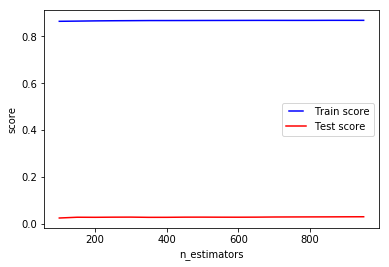

In [61]:
n_estimators = [*range(100, 1000, 50)]
line1, = plt.plot(n_estimators, train_scores, 'b', label='Train score')
line2, = plt.plot(n_estimators, test_scores, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.show()

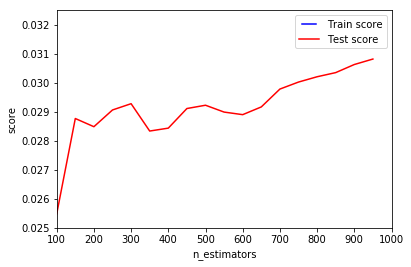

In [68]:
#zoom in
line1, = plt.plot(n_estimators, train_scores, 'b', label='Train score')
line2, = plt.plot(n_estimators, test_scores, 'r', label='Test score')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.ylim(0.025,0.0325)
plt.xlim(100,1000)
plt.show()

In [70]:
#Build the model
mortgage_rfmodel = RandomForestRegressor(n_estimators = 1000,random_state = 123) 
mortgage_rfmodel.fit(X_train, Y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

# SHAP 

## The summary_plot

In [116]:
#!pip install shap

    100% |████████████████████████████████| 296kB 2.3MB/s ta 0:00:01


In [71]:
import shap

In [72]:
shap_values = shap.TreeExplainer(mortgage_rfmodel).shap_values(X_train)


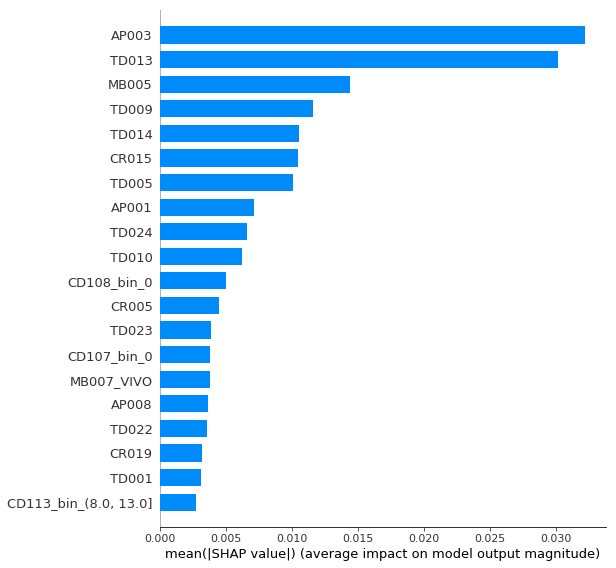

In [74]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

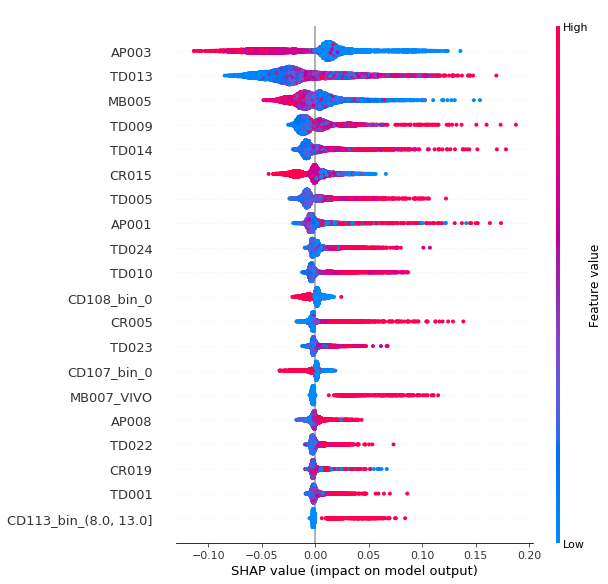

In [73]:
shap.summary_plot(shap_values, X_train)

### According to the information shows in the summary plot, we can see the impact of variables toward the prediction. Also, the variables are ranked in descending order, which means the first variable: AP003 has the most significant impact on the prediction.  Interpretation about the top 5 important variables are listed below:
* AP003 represents education level. It has a negative relationship with loan-default; The lower the education level a person has, the higher the probability of loan default
* TD013 related to the number of query about P2P in last 6 months. It has a positive impact on the loan-default prediction; The higher the value shows in TD013, the higher the probability of loan default happen
* MB005 means the number of years that phone has been activated. We can see that MB005 is negatively correlated with the target variable: loan-default, which means that people with a long time actived phone is less possible to default loan
* TD009 related to the number of query about P2P in last 3 months. It has a positive impact on the loan-default prediction; The higher the value shows in TD009, the higher the probability of loan-default happen 
* TD014 related to the number of query about small loan in last 6 months. It has a positive impact on the loan-default prediction; The higher the value shows in TD014, the higher the probability of loan-default happen. 

## The dependence_plot

The following plot shows AP003 highly interact with TD013. As we can see, it only shows a sigle blue point when AP003 = 6. To some point, AP003(education level) has inperfect negative relationship with TD013(TD_CNT_QUERY_LAST_6MON_P2P). For low education level, AP003 =1, TD013 has a high value, while as the education level increasing, the value of TD013 is not decreasing significantly. 

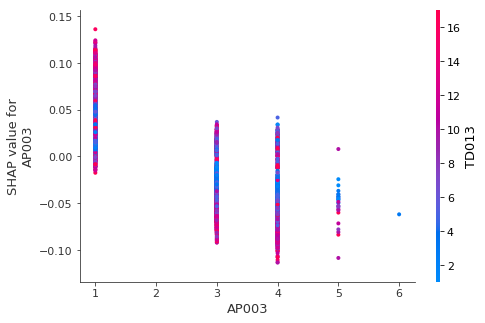

In [88]:
shap.dependence_plot("AP003", shap_values, X_train)

The following plot shows TD013(QUERY_LAST_6MON_P2P) highly interact with TD010(QUERY_LAST_3MON_SMALL_LOAN).There is no obvious linear relationship between TD013 and TD010. But we could know, when the value in TD013 is small, such as below 25, the blue dots shows more frequently; When the value of TD013 becomes bigger, red dots appear more. 

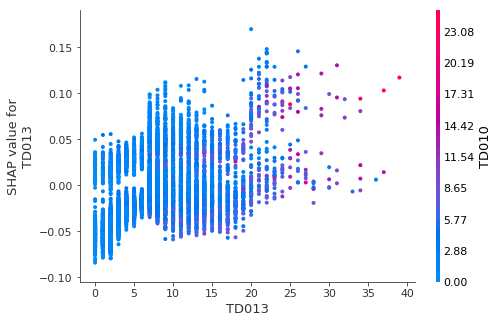

In [90]:
shap.dependence_plot("TD013", shap_values, X_train)

The following plot displayed as "U" shape and shows MB005(YR_PHONE_ACTIVE) high interactivity with AP003(EDUCATION).There is no obvious linear relationship between MB005 and AP003.

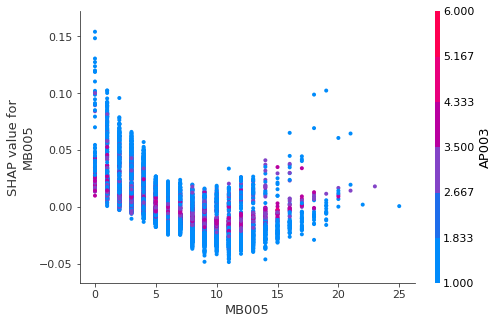

In [91]:
shap.dependence_plot("MB005", shap_values, X_train)

The following plot shows TD009(QUERY_LAST_3MON_P2P) highly interact with AP003(EDUCATION).There is no obvious linear relationship between TD009 and AP003. But we could know, when the value in TD009 is small, the blue dots shows more frequently; When the value of TD009 becomes bigger, red dots appear more correspondingly. 

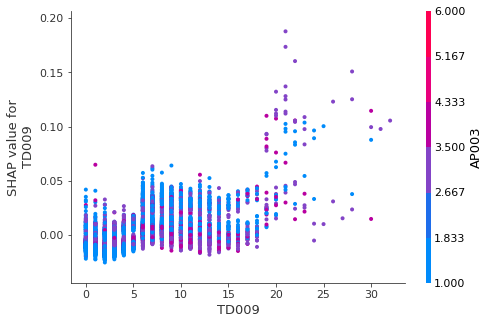

In [92]:
shap.dependence_plot("TD009", shap_values, X_train)

The following plot shows TD014(QUERY_LAST_6MON_SMALL_LOAN) highly interact with TD009(QUERY_LAST_3MON_P2P). An approximately linear positive trend shows in the plot. When TD014 is small, the value of TD009 usually small as well. As the value of TD014 raise up, TD009 becomes larger. 

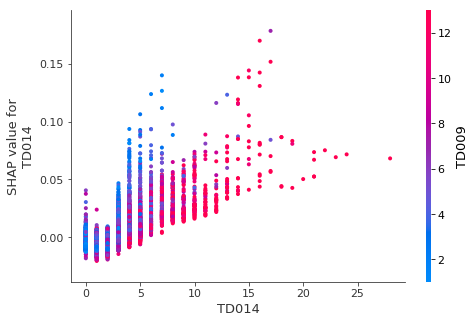

In [93]:
shap.dependence_plot("TD014", shap_values, X_train)

## The force_plot with 4 observation

In [126]:
# Use to interpret the force plot later
X_train.mean()

TD013             6.763153
AP003             1.980131
TD009             5.358582
TD005             3.563619
TD014             2.589739
MB005             5.906716
CR015             4.923601
TD010             2.011847
TD023             7.156623
AP001            31.700653
AP007             3.284049
TD024             5.422201
TD001             1.969310
CR019             6.178545
AP008             3.106996
CR004             2.497761
CR018             4.339366
CR017             5.219683
AP002             1.325746
TD006             1.343750
CD108_bin_0       0.382743
AP006_ios         0.219590
TD022            16.505131
AP006_h5          0.550000
month_4           0.235448
CR005             1.569496
TD015             0.706810
MB007_WEB         0.545056
CD101_bin_0       0.425373
TD002             0.700466
                   ...    
CD117_bin_-99     0.040858
CD118_bin_0       0.002612
CD120_bin_0       0.003918
CD121_bin_0       0.000746
CD121_bin_-99     0.040858
CD123_bin_0       0.001399
C

In [111]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(mortgage_rfmodel.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) 
S = X_output.iloc[random_picks]
S

,TD013,AP003,TD009,TD005,TD014,MB005,CR015,TD010,TD023,AP001,...,CD153_bin_-99,CD160_bin_-99,CD162_bin_0,CD162_bin_-99,CD164_bin_-99,CD166_bin_-99,CD169_bin_-99,CD170_bin_-99,CD173_bin_-99,predict
3674,7,1,4,2,2,4.0,5,2,3.0,36,...,0,0,0,0,0,0,0,0,0,0.20
69927,6,4,6,5,1,3.0,2,1,15.0,25,...,0,0,0,0,0,0,0,0,0,0.21
4387,16,3,12,5,5,9.0,3,3,9.0,31,...,0,0,0,0,0,0,0,0,0,0.29
79726,6,3,6,5,2,2.0,4,4,9.0,22,...,0,0,0,0,0,0,0,0,0,0.23
3775,6,1,5,4,3,2.0,6,2,6.0,41,...,0,0,0,0,0,0,0,0,0,0.21
47917,3,4,3,1,1,10.0,5,1,0.0,29,...,0,0,0,0,0,0,0,0,0,0.10
26894,9,1,6,6,2,4.0,6,1,6.0,31,...,0,0,0,0,0,0,0,0,0,0.26


In [94]:
shap.initjs()

In [114]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(mortgage_rfmodel)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [115]:
shap_plot(0)

In [116]:
shap_plot(1)

In [117]:
shap_plot(2)

In [118]:
shap_plot(3)

### To explain the force plot, I will take the last observation as an example.
The force plot tells how the variables contribute in the prediction. For the last plot, the output value: the predictive loan-default rate is 0.23 and the base value is 0.1909. Features show in red, which are TD010, AP001, and TD002 push the prediction higher and features show in blue, which are AP003 push the the prediction lower.
* TD010 (QUERY_LAST_3MON_SMALL_LOAN) has a positive impart on the loan-default prediction. As the information shown in the plot, TD010 = 4 which is higher than the average value 2.011847. So it push the prediction to the right
* AP001 (AGE) has a negative impact on the loan-default prediction. As the information shown in the plot, AP001 = 22 which is lower than the average value 31.700653. So it push the prediction to the right
* TD002 (QUERY_LAST_7Day_SMALL_LOAN) has a positive impact on the loan-default prediction. As the information shown in the plot TD002 = 3 which is higher than the average value 0.700466. So it push the prediction to the right
* AP003 (EDUCATION) has a negative impact on the loan-default prediction. As the information shown in the plot, AP003 = 3 which is higher than the average value 1.980131. So it push the prediction to the left

In [ ]:
#END